# Data Loading

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [2]:
application = pd.read_csv("application_record.csv", encoding = 'utf-8') 
credit = pd.read_csv("credit_record.csv", encoding = 'utf-8')  

In [3]:
#plt.rcParams['figure.facecolor'] = 'white'

# Brief Analysis of Binary and Continuous Features

### Find out the percentage of approved and rejected clients - using yes and no

In [4]:
# find all users' account open month.
begin_month=pd.DataFrame(credit.groupby(["ID"])["MONTHS_BALANCE"].agg(min))
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'begin_month'}) 
new_data=pd.merge(application,begin_month,how="left",on="ID") #merge to record data

In [5]:
credit['dep_value'] = None
credit['dep_value'][credit['STATUS'] =='2']='Yes' 
credit['dep_value'][credit['STATUS'] =='3']='Yes' 
credit['dep_value'][credit['STATUS'] =='4']='Yes' 
credit['dep_value'][credit['STATUS'] =='5']='Yes' 

In [6]:
cpunt=credit.groupby('ID').count()
cpunt['dep_value'][cpunt['dep_value'] > 0]='Yes' 
cpunt['dep_value'][cpunt['dep_value'] == 0]='No' 
cpunt = cpunt[['dep_value']]
new_data=pd.merge(new_data,cpunt,how='inner',on='ID')
new_data['target']=new_data['dep_value']
new_data.loc[new_data['target']=='Yes','target']=1
new_data.loc[new_data['target']=='No','target']=0

In [7]:
print(cpunt['dep_value'].value_counts())
cpunt['dep_value'].value_counts(normalize=True)

No     45318
Yes      667
Name: dep_value, dtype: int64


No     0.985495
Yes    0.014505
Name: dep_value, dtype: float64

### Rename all features

In [8]:
# RENAME FEATURES

new_data.rename(columns={'CODE_GENDER':'Gender','FLAG_OWN_CAR':'Car','FLAG_OWN_REALTY':'Reality',
                         'CNT_CHILDREN':'ChldNo','AMT_INCOME_TOTAL':'inc',
                         'NAME_EDUCATION_TYPE':'edutp','NAME_FAMILY_STATUS':'famtp',
                        'NAME_HOUSING_TYPE':'houtp','FLAG_EMAIL':'email',
                         'NAME_INCOME_TYPE':'inctp','FLAG_WORK_PHONE':'wkphone',
                         'FLAG_PHONE':'phone','CNT_FAM_MEMBERS':'famsize',
                        'OCCUPATION_TYPE':'occyp'
                        },inplace=True)

In [9]:
new_data.dropna()
new_data = new_data.mask(new_data == 'NULL').dropna()

In [10]:
ivtable=pd.DataFrame(new_data.columns,columns=['variable'])
ivtable['IV']=None
namelist = ['FLAG_MOBIL','begin_month','dep_value','target','ID']

for i in namelist:
    ivtable.drop(ivtable[ivtable['variable'] == i].index, inplace=True)

### Functions of IV and WoE

In [11]:
# Calculate information value
def calc_iv(df, feature, target, pr=False):
    lst = []
    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (think: Fraud == 0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad (think: Fraud == 1)

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])
    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])
    
    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())

    iv = data['IV'].sum()
    print('This variable\'s IV is:',iv)
    print(df[feature].value_counts())
    return iv, data

In [12]:
def convert_dummy(df, feature,rank=0):
    pos = pd.get_dummies(df[feature], prefix=feature)
    mode = df[feature].value_counts().index[rank]
    biggest = feature + '_' + str(mode)
    pos.drop([biggest],axis=1,inplace=True)
    df.drop([feature],axis=1,inplace=True)
    df=df.join(pos)
    return df

In [13]:
def get_category(df, col, binsnum, labels, qcut = False):
    if qcut:
        localdf = pd.qcut(df[col], q = binsnum, labels = labels) # quantile cut
    else:
        localdf = pd.cut(df[col], bins = binsnum, labels = labels) # equal-length cut
        
    localdf = pd.DataFrame(localdf)
    name = 'gp' + '_' + col
    localdf[name] = localdf[col]
    df = df.join(localdf[name])
    df[name] = df[name].astype(object)
    return df

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Brief analysis of all features

#### Binary Features

###### Gender

In [15]:
new_data['Gender'] = new_data['Gender'].replace(['F','M'],[0,1])
print(new_data['Gender'].value_counts())
iv, data = calc_iv(new_data,'Gender','target')
ivtable.loc[ivtable['variable']=='Gender','IV']=iv
data.head()

0    15630
1     9504
Name: Gender, dtype: int64
This variable's IV is: 0.02520350452745081
0    15630
1     9504
Name: Gender, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Gender,0,15630,15400,230,0.621867,0.014715,0.623179,0.545024,0.134005,0.010473
1,Gender,1,9504,9312,192,0.378133,0.020202,0.376821,0.454976,-0.188475,0.014730


###### Having a car or not

In [16]:
new_data['Car'] = new_data['Car'].replace(['N','Y'],[0,1])
print(new_data['Car'].value_counts())
iv, data=calc_iv(new_data,'Car','target')
ivtable.loc[ivtable['variable']=='Car','IV']=iv
data.head()

0    14618
1    10516
Name: Car, dtype: int64
This variable's IV is: 4.54248124999671e-06
0    14618
1    10516
Name: Car, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Car,0,14618,14373,245,0.581603,0.016760,0.58162,0.580569,0.00181,0.000002
1,Car,1,10516,10339,177,0.418397,0.016831,0.41838,0.419431,-0.00251,0.000003


###### Having house reality or not

In [17]:
new_data['Reality'] = new_data['Reality'].replace(['N','Y'],[0,1])
print(new_data['Reality'].value_counts())
iv, data=calc_iv(new_data,'Reality','target')
ivtable.loc[ivtable['variable']=='Reality','IV']=iv
data.head()

1    16461
0     8673
Name: Reality, dtype: int64
This variable's IV is: 0.02744070350168343
1    16461
0     8673
Name: Reality, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Reality,0,8673,8494,179,0.34507,0.020639,0.34372,0.424171,-0.210309,0.016920
1,Reality,1,16461,16218,243,0.65493,0.014762,0.65628,0.575829,0.130777,0.010521


###### Having a phone or not

In [18]:
new_data['phone']=new_data['phone'].astype(str)
print(new_data['phone'].value_counts(normalize=True,sort=False))
new_data.drop(new_data[new_data['phone'] == 'nan' ].index, inplace=True)
iv, data=calc_iv(new_data,'phone','target')
ivtable.loc[ivtable['variable']=='phone','IV']=iv
data.head()

0    0.707209
1    0.292791
Name: phone, dtype: float64
This variable's IV is: 0.0005480495762639297
0    17775
1     7359
Name: phone, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,phone,0,17775,17481,294,0.707209,0.016540,0.707389,0.696682,0.015251,0.000163
1,phone,1,7359,7231,128,0.292791,0.017394,0.292611,0.303318,-0.035937,0.000385


###### Having an email or not

In [19]:
print(new_data['email'].value_counts(normalize=True,sort=False))
new_data['email']=new_data['email'].astype(str)
iv, data=calc_iv(new_data,'email','target')
ivtable.loc[ivtable['variable']=='email','IV']=iv
data.head()

0    0.89934
1    0.10066
Name: email, dtype: float64
This variable's IV is: 1.7343581493999816e-05
0    22604
1     2530
Name: email, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,email,0,22604,22225,379,0.89934,0.016767,0.899361,0.898104,0.001398,0.000002
1,email,1,2530,2487,43,0.10066,0.016996,0.100639,0.101896,-0.012407,0.000016


###### Having a Work phone or not

In [20]:
new_data['wkphone']=new_data['wkphone'].astype(str)
iv, data = calc_iv(new_data,'wkphone','target')
new_data.drop(new_data[new_data['wkphone'] == 'nan' ].index, inplace=True)
ivtable.loc[ivtable['variable']=='wkphone','IV']=iv
data.head()

This variable's IV is: 0.002042429795148461
0    18252
1     6882
Name: wkphone, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,wkphone,0,18252,17954,298,0.726188,0.016327,0.72653,0.706161,0.028436,0.000579
1,wkphone,1,6882,6758,124,0.273812,0.018018,0.27347,0.293839,-0.071838,0.001463


#### Continuous Features

###### Children Numbers

In [21]:
new_data.loc[new_data['ChldNo'] >= 2,'ChldNo']='2More'
print("total number of values: ", new_data['ChldNo'].value_counts(sort=False))

iv, data=calc_iv(new_data,'ChldNo','target')
ivtable.loc[ivtable['variable']=='ChldNo','IV']=iv
data.head()


total number of values:  0        15908
2More     3108
1         6118
Name: ChldNo, dtype: int64
This variable's IV is: 0.0011214542503301935
0        15908
1         6118
2More     3108
Name: ChldNo, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,ChldNo,0,15908,15635,273,0.632928,0.017161,0.632689,0.646919,-0.022243,0.000317
1,ChldNo,1,6118,6021,97,0.243415,0.015855,0.243647,0.229858,0.058259,0.000803
2,ChldNo,2More,3108,3056,52,0.123657,0.016731,0.123665,0.123223,0.003580,0.000002


In [22]:
new_data = convert_dummy(new_data,'ChldNo')

###### Annual Income

(2.544, 18.18]      14663
(18.18, 33.66]       8464
(33.66, 49.14]       1637
(49.14, 64.62]        175
(64.62, 80.1]         124
(80.1, 95.58]          50
(95.58, 111.06]         4
(111.06, 126.54]        3
(126.54, 142.02]        6
(142.02, 157.5]         8
Name: inc, dtype: int64


<AxesSubplot:ylabel='Frequency'>

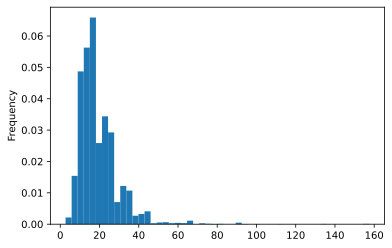

In [23]:
new_data['inc']=new_data['inc'].astype(object)
new_data['inc'] = new_data['inc']/10000 
print(new_data['inc'].value_counts(bins=10,sort=False))
new_data['inc'].plot(kind='hist',bins=50,density=True)

In [24]:
new_data = get_category(new_data,'inc', 3, ["low","medium", "high"], qcut = True)
iv, data = calc_iv(new_data,'gp_inc','target')
ivtable.loc[ivtable['variable']=='inc','IV']=iv
data.head()

new_data = convert_dummy(new_data,'gp_inc')

This variable's IV is: 0.0024219962221596752
low       8996
high      8244
medium    7894
Name: gp_inc, dtype: int64


###### Age

(19.951999999999998, 24.7]    0.025066
(24.7, 29.4]                  0.134280
(29.4, 34.1]                  0.169770
(34.1, 38.8]                  0.140805
(38.8, 43.5]                  0.173072
(43.5, 48.2]                  0.141880
(48.2, 52.9]                  0.099069
(52.9, 57.6]                  0.076550
(57.6, 62.3]                  0.032585
(62.3, 67.0]                  0.006923
Name: Age, dtype: float64


<AxesSubplot:ylabel='Frequency'>

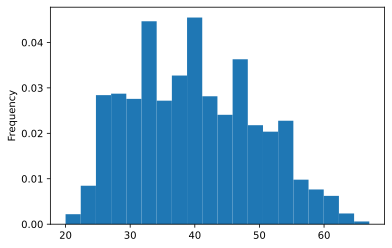

In [25]:
new_data['Age']=-(new_data['DAYS_BIRTH'])//365	
print(new_data['Age'].value_counts(bins=10,normalize=True,sort=False))
new_data['Age'].plot(kind='hist',bins=20,density=True)

In [26]:
new_data = get_category(new_data,'Age',5, ["lowest","low","medium","high","highest"])
iv, data = calc_iv(new_data,'gp_Age','target')
ivtable.loc[ivtable['variable']=='DAYS_BIRTH','IV'] = iv
data.head()

new_data = convert_dummy(new_data,'gp_Age')

This variable's IV is: 0.06593513858884348
medium     7916
low        7806
high       4414
lowest     4005
highest     993
Name: gp_Age, dtype: int64


###### Working Years

<AxesSubplot:ylabel='Frequency'>

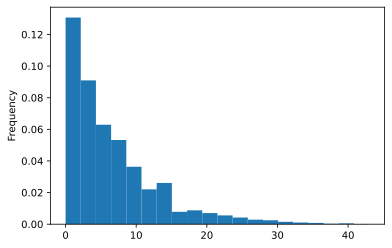

In [27]:
new_data['worktm']=-(new_data['DAYS_EMPLOYED'])//365	
new_data[new_data['worktm']<0] = np.nan # replace by na
new_data['DAYS_EMPLOYED']
new_data['worktm'].fillna(new_data['worktm'].mean(),inplace=True) #replace na by mean
new_data['worktm'].plot(kind='hist',bins=20,density=True)

In [28]:
new_data = get_category(new_data,'worktm',5, ["lowest","low","medium","high","highest"])
iv, data=calc_iv(new_data,'gp_worktm','target')
ivtable.loc[ivtable['variable']=='DAYS_EMPLOYED','IV']=iv
data.head()

new_data = convert_dummy(new_data,'gp_worktm')

This variable's IV is: 0.04022152230816303
lowest     18254
low         4987
medium      1378
high         425
highest       90
Name: gp_worktm, dtype: int64


###### Family size

In [29]:
new_data['famsize'].value_counts(sort=False)

2.0     12697
1.0      4263
5.0       307
3.0      5216
4.0      2576
6.0        51
15.0        3
7.0        18
20.0        1
9.0         2
Name: famsize, dtype: int64

In [30]:
new_data['famsize']=new_data['famsize'].astype(int)
new_data['famsizegp']=new_data['famsize']
new_data['famsizegp']=new_data['famsizegp'].astype(object)
new_data.loc[new_data['famsizegp']>=3,'famsizegp']='3more'
iv, data=calc_iv(new_data,'famsizegp','target')
ivtable.loc[ivtable['variable']=='famsize','IV']=iv
data.head()

This variable's IV is: 0.006156138510778323
2        12697
3more     8174
1         4263
Name: famsizegp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,famsizegp,1,4263,4179,84,0.169611,0.019704,0.169108,0.199052,-0.163028,0.004882
1,famsizegp,2,12697,12489,208,0.505172,0.016382,0.505382,0.492891,0.025027,0.000313
2,famsizegp,3more,8174,8044,130,0.325217,0.015904,0.325510,0.308057,0.055108,0.000962


In [31]:
new_data = convert_dummy(new_data,'famsizegp')

#### Categorical Features

###### Income type

In [32]:
print(new_data['inctp'].value_counts(sort=False))
print(new_data['inctp'].value_counts(normalize=True,sort=False))
new_data.loc[new_data['inctp']=='Pensioner','inctp']='State servant'
new_data.loc[new_data['inctp']=='Student','inctp']='State servant'
iv, data=calc_iv(new_data,'inctp','target')
ivtable.loc[ivtable['variable']=='inctp','IV']=iv
data.head()

Working                 15622
Commercial associate     7052
State servant            2437
Student                    10
Pensioner                  13
Name: inctp, dtype: int64
Working                 0.621549
Commercial associate    0.280576
State servant           0.096960
Student                 0.000398
Pensioner               0.000517
Name: inctp, dtype: float64
This variable's IV is: 5.159303327851404e-05
Working                 15622
Commercial associate     7052
State servant            2460
Name: inctp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,inctp,Commercial associate,7052,6933,119,0.280576,0.016875,0.280552,0.281991,-0.005115,0.000007
1,inctp,State servant,2460,2418,42,0.097875,0.017073,0.097847,0.099526,-0.017013,0.000029
2,inctp,Working,15622,15361,261,0.621549,0.016707,0.621601,0.618483,0.005028,0.000016


In [33]:
new_data = convert_dummy(new_data,'inctp')

###### Occupation type

In [34]:
new_data.loc[(new_data['occyp']=='Cleaning staff') | (new_data['occyp']=='Cooking staff') | (new_data['occyp']=='Drivers') | (new_data['occyp']=='Laborers') | (new_data['occyp']=='Low-skill Laborers') | (new_data['occyp']=='Security staff') | (new_data['occyp']=='Waiters/barmen staff'),'occyp']='Laborwk'
new_data.loc[(new_data['occyp']=='Accountants') | (new_data['occyp']=='Core staff') | (new_data['occyp']=='HR staff') | (new_data['occyp']=='Medicine staff') | (new_data['occyp']=='Private service staff') | (new_data['occyp']=='Realty agents') | (new_data['occyp']=='Sales staff') | (new_data['occyp']=='Secretaries'),'occyp']='officewk'
new_data.loc[(new_data['occyp']=='Managers') | (new_data['occyp']=='High skill tech staff') | (new_data['occyp']=='IT staff'),'occyp']='hightecwk'
print(new_data['occyp'].value_counts())
iv, data=calc_iv(new_data,'occyp','target')
ivtable.loc[ivtable['variable']=='occyp','IV']=iv
data.head()         

Laborwk      10496
officewk     10183
hightecwk     4455
Name: occyp, dtype: int64
This variable's IV is: 0.004820472062853304
Laborwk      10496
officewk     10183
hightecwk     4455
Name: occyp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,occyp,Laborwk,10496,10311,185,0.417602,0.017626,0.417247,0.438389,-0.049428,0.001045
1,occyp,hightecwk,4455,4375,80,0.177250,0.017957,0.177039,0.189573,-0.068404,0.000857
2,occyp,officewk,10183,10026,157,0.405148,0.015418,0.405714,0.372038,0.086652,0.002918


In [35]:
new_data = convert_dummy(new_data,'occyp')

###### House type

In [36]:
iv, data=calc_iv(new_data,'houtp','target')
ivtable.loc[ivtable['variable']=='houtp','IV']=iv
data.head()

This variable's IV is: 0.0073275026880227365
House / apartment      22102
With parents            1430
Municipal apartment      812
Rented apartment         439
Office apartment         199
Co-op apartment          152
Name: houtp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,houtp,Co-op apartment,152,149,3,0.006048,0.019737,0.006029,0.007109,-0.164705,0.000178
1,houtp,House / apartment,22102,21738,364,0.879367,0.016469,0.879654,0.862559,0.019624,0.000335
2,houtp,Municipal apartment,812,793,19,0.032307,0.023399,0.032090,0.045024,-0.338655,0.004380
3,houtp,Office apartment,199,194,5,0.007918,0.025126,0.007850,0.011848,-0.411619,0.001646
4,houtp,Rented apartment,439,433,6,0.017466,0.013667,0.017522,0.014218,0.208939,0.000690


In [37]:
new_data = convert_dummy(new_data,'houtp')

###### Education

In [38]:
new_data.loc[new_data['edutp']=='Academic degree','edutp']='Higher education'
iv, data=calc_iv(new_data,'edutp','target')
ivtable.loc[ivtable['variable']=='edutp','IV']=iv
data.head()

This variable's IV is: 0.010361794017679489
Secondary / secondary special    16808
Higher education                  7146
Incomplete higher                  993
Lower secondary                    187
Name: edutp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,edutp,Higher education,7146,7018,128,0.284316,0.017912,0.283992,0.303318,-0.065836,0.001272
1,edutp,Incomplete higher,993,972,21,0.039508,0.021148,0.039333,0.049763,-0.235206,0.002453
2,edutp,Lower secondary,187,181,6,0.007440,0.032086,0.007324,0.014218,-0.663301,0.004573
3,edutp,Secondary / secondary special,16808,16541,267,0.668736,0.015885,0.669351,0.632701,0.056310,0.002064


In [39]:
new_data = convert_dummy(new_data,'edutp')

###### Marriage condition

In [40]:
new_data['famtp'].value_counts(normalize=True,sort=False)

Married                 0.696626
Single / not married    0.137065
Civil marriage          0.084865
Separated               0.058367
Widow                   0.023076
Name: famtp, dtype: float64

In [41]:
iv, data=calc_iv(new_data,'famtp','target')
ivtable.loc[ivtable['variable']=='famtp','IV']=iv
data.head()

This variable's IV is: 0.043137115423127946
Married                 17509
Single / not married     3445
Civil marriage           2133
Separated                1467
Widow                     580
Name: famtp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,famtp,Civil marriage,2133,2101,32,0.084865,0.015002,0.085019,0.075829,0.114394,0.001051
1,famtp,Married,17509,17232,277,0.696626,0.015820,0.697313,0.656398,0.060467,0.002474
2,famtp,Separated,1467,1452,15,0.058367,0.010225,0.058757,0.035545,0.502608,0.011666
3,famtp,Single / not married,3445,3362,83,0.137065,0.024093,0.136047,0.196682,-0.368588,0.022349
4,famtp,Widow,580,565,15,0.023076,0.025862,0.022863,0.035545,-0.441263,0.005596


In [42]:
new_data = convert_dummy(new_data,'famtp')

#### IV & WOE of features

In [43]:
ivtable=ivtable.sort_values(by='IV',ascending=False)
ivtable.loc[ivtable['variable']=='DAYS_BIRTH','variable']='agegp'
ivtable.loc[ivtable['variable']=='DAYS_EMPLOYED','variable']='worktmgp'
ivtable.loc[ivtable['variable']=='inc','variable']='incgp'
ivtable

,variable,IV
10,agegp,0.065935
8,famtp,0.043137
11,worktmgp,0.040222
3,Reality,0.027441
1,Gender,0.025204
7,edutp,0.010362
9,houtp,0.007328
17,famsize,0.006156
16,occyp,0.00482
5,incgp,0.002422


# Model fitting and performance

### Reconstruct the features

In [44]:
new_data.columns

Index(['ID', 'Gender', 'Car', 'Reality', 'inc', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'wkphone', 'phone', 'email', 'famsize', 'begin_month',
       'dep_value', 'target', 'ChldNo_1', 'ChldNo_2More', 'gp_inc_high',
       'gp_inc_medium', 'Age', 'gp_Age_high', 'gp_Age_highest', 'gp_Age_low',
       'gp_Age_lowest', 'worktm', 'gp_worktm_high', 'gp_worktm_highest',
       'gp_worktm_low', 'gp_worktm_medium', 'famsizegp_1', 'famsizegp_3more',
       'inctp_Commercial associate', 'inctp_State servant', 'occyp_hightecwk',
       'occyp_officewk', 'houtp_Co-op apartment', 'houtp_Municipal apartment',
       'houtp_Office apartment', 'houtp_Rented apartment',
       'houtp_With parents', 'edutp_Higher education',
       'edutp_Incomplete higher', 'edutp_Lower secondary',
       'famtp_Civil marriage', 'famtp_Separated', 'famtp_Single / not married',
       'famtp_Widow'],
      dtype='object')

In [45]:
new_data

,ID,Gender,Car,Reality,inc,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,wkphone,phone,...,houtp_Office apartment,houtp_Rented apartment,houtp_With parents,edutp_Higher education,edutp_Incomplete higher,edutp_Lower secondary,famtp_Civil marriage,famtp_Separated,famtp_Single / not married,famtp_Widow
2,5008806.0,1.0,1.0,1.0,11.25,-21474.0,-1134.0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5008808.0,0.0,0.0,1.0,27.0,-19110.0,-3051.0,1.0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,5008809.0,0.0,0.0,1.0,27.0,-19110.0,-3051.0,1.0,0,1,...,0,0,0,0,0,0,0,0,1,0
5,5008810.0,0.0,0.0,1.0,27.0,-19110.0,-3051.0,1.0,0,1,...,0,0,0,0,0,0,0,0,1,0
6,5008811.0,0.0,0.0,1.0,27.0,-19110.0,-3051.0,1.0,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828.0,1.0,1.0,1.0,31.5,-17348.0,-2420.0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
36453,5149834.0,0.0,0.0,1.0,15.75,-12387.0,-1325.0,1.0,0,1,...,0,0,0,1,0,0,0,0,0,0
36454,5149838.0,0.0,0.0,1.0,15.75,-12387.0,-1325.0,1.0,0,1,...,0,0,0,1,0,0,0,0,0,0
36455,5150049.0,0.0,0.0,1.0,28.35,-17958.0,-655.0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
Y = new_data['target']
X = new_data[['Gender','Reality','ChldNo_1', 'ChldNo_2More','wkphone',
              'gp_Age_high', 'gp_Age_highest', 'gp_Age_low',
       'gp_Age_lowest','gp_worktm_high', 'gp_worktm_highest',
       'gp_worktm_low', 'gp_worktm_medium','occyp_hightecwk', 
              'occyp_officewk','famsizegp_1', 'famsizegp_3more',
       'houtp_Co-op apartment', 'houtp_Municipal apartment',
       'houtp_Office apartment', 'houtp_Rented apartment',
       'houtp_With parents','edutp_Higher education',
       'edutp_Incomplete higher', 'edutp_Lower secondary','famtp_Civil marriage',
       'famtp_Separated','famtp_Single / not married','famtp_Widow']]

### Use SMOTE to balance the data

In [47]:
from imblearn.over_sampling import SMOTE

In [48]:
Y = Y.astype('int')
X_balance, Y_balance = SMOTE().fit_resample(X,Y)
X_balance = pd.DataFrame(X_balance, columns = X.columns)

### Split the balanced data set

In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_balance, Y_balance, stratify=Y_balance, test_size=0.3, random_state = 10086)

# set random seed
np.random.seed(100)

### Logistic regression

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

In [51]:
for i in range(1, 5):
    model = LogisticRegression(C=i, random_state=0, solver='lbfgs')
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)

    print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))

Accuracy Score is 0.65134
Accuracy Score is 0.65053
Accuracy Score is 0.651
Accuracy Score is 0.64992


Here we apply the method of grid search for each hyperparameter we want to select.

As we can see, there is no much difference between the accuracy when we change c, which is the inverse of regularization strength.

So then we try to change the solver with c fixed as 0.8.

In [52]:
for i in ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'):
    model = LogisticRegression(C=0.8, random_state=0, solver=i)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)

    print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))

Accuracy Score is 0.65127
Accuracy Score is 0.65127
Accuracy Score is 0.65127
Accuracy Score is 0.65127
Accuracy Score is 0.65127


Still, there is no much big difference. After comparing the results, we decide to use c as 0.8 and the solver as lbfgs.

Accuracy Score is 0.65127
      0     1
0  4188  3226
1  1945  5469
[[0.56487726 0.43512274]
 [0.26234152 0.73765848]]


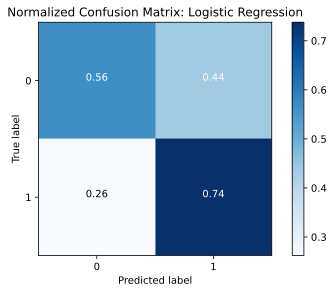

In [53]:
model_lr = LogisticRegression(C=0.8, random_state=0, solver='lbfgs')
fit_lr = model.fit(X_train, y_train)
y_predict_lr = model.predict(X_test)

# print the accuracy and the confusion matrix
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

# plot the confusion matrix
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test,y_predict), classes= class_names, normalize = True, 
                      title='Normalized Confusion Matrix: Logistic Regression')

### Cross validation of logistic regression

In [54]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model_lr, X_test, y_test, cv=5, scoring='f1')

print("Logistic regression: " + "%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

Logistic regression: 0.68 accuracy with a standard deviation of 0.00


### Random forest

In [55]:
np.random.seed(100)
for esti in (50, 100, 150, 200, 250, 300):
    model = RandomForestClassifier(n_estimators=esti, max_depth=12, min_samples_leaf=16)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)

    print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))

Accuracy Score is 0.83848
Accuracy Score is 0.8316
Accuracy Score is 0.83315
Accuracy Score is 0.83558
Accuracy Score is 0.83457
Accuracy Score is 0.83396


As we can see, the best accuracy is reached when the number of estimators is 100.(Although the result may fluctuate a little.)

In [56]:
for i in (1,5,10,15,20,25,30,40):
    model = RandomForestClassifier(n_estimators=100, max_depth=i, min_samples_leaf=16)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)

    print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))

Accuracy Score is 0.6218
Accuracy Score is 0.75674
Accuracy Score is 0.82162
Accuracy Score is 0.85521
Accuracy Score is 0.86627
Accuracy Score is 0.87099
Accuracy Score is 0.87031
Accuracy Score is 0.87031


We could find that when max depth increases, the accuracy will also increase. 

But after max depth reaches 20, the accuracy fluctuate near 0.87. So here we use max_depth=20.

In [57]:
for esti in (1,5,10,15,16,20):
    model = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_leaf=i)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)

    print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))

Accuracy Score is 0.84037
Accuracy Score is 0.8345
Accuracy Score is 0.83538
Accuracy Score is 0.83727
Accuracy Score is 0.83666
Accuracy Score is 0.83578


There is no big difference between the results when we change the min samples leaf. Here we use min_samples_leaf=16.

Accuracy Score is 0.83909
      0     1
0  6286  1128
1  1258  6156
[[0.84785541 0.15214459]
 [0.16967899 0.83032101]]


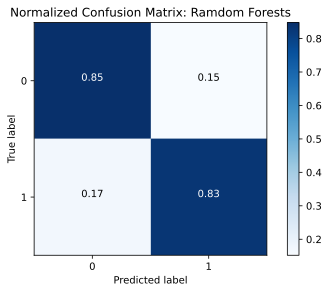

In [58]:
model_rf = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_leaf=16)
fit_rf = model.fit(X_train, y_train)
y_predict = model.predict(X_test)

print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))
plot_confusion_matrix(confusion_matrix(y_test,y_predict), classes=class_names, normalize = True, 
                      title='Normalized Confusion Matrix: Ramdom Forests')

### Cross validation of random forest

In [59]:
scores = cross_val_score(model_rf, X_test, y_test, cv=5, scoring='f1')
print("Random forest: " + "%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

Random forest: 0.83 accuracy with a standard deviation of 0.01


### Support vector machine (SVM)

In [60]:
from sklearn import svm
for i in (0.05, 0.1, 1, 5, 10):
    model = svm.SVC(C = i, kernel='linear')
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)

    print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))

Accuracy Score is 0.64264
Accuracy Score is 0.64297
Accuracy Score is 0.64297
Accuracy Score is 0.64297
Accuracy Score is 0.64297


The accuracy does not change much when the value of C is bigger than 0.1. So here we just use C=0.8 and further 

In [61]:
for kernel in ('linear', 'poly', 'rbf', 'sigmoid'):
    model = svm.SVC(C = 0.8, kernel=kernel)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)

    print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))


Accuracy Score is 0.64297
Accuracy Score is 0.83275
Accuracy Score is 0.8602
Accuracy Score is 0.5054


As we can see, the model has better performance when the kernel is polynomial or rbf. So next we will use the SVM model with kernel as rbf.

Accuracy Score is 0.5054
      0     1
0  3757  3657
1  3677  3737
[[0.506744  0.493256 ]
 [0.4959536 0.5040464]]


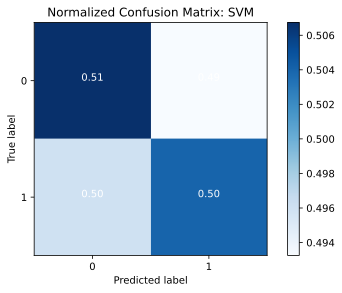

In [62]:
model_svm = svm.SVC(C = 0.8, kernel='rbf')
fit_svm = model.fit(X_train, y_train)
y_predict = model.predict(X_test)

print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))

print(pd.DataFrame(confusion_matrix(y_test,y_predict)))
plot_confusion_matrix(confusion_matrix(y_test,y_predict), classes=class_names, normalize = True, title='Normalized Confusion Matrix: SVM')

### Cross validation of SVM

In [63]:
scores = cross_val_score(model_svm, X_test, y_test, cv=5, scoring='f1')
print("SVM: " + "%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

SVM: 0.85 accuracy with a standard deviation of 0.01
